Alright, so this may be a bit more annoying than the _E. coli_ analysis, mostly for the fact that both Enterobacteriacea and Enterobacterales were lumped together in the analysis, and that I need to know how many species there were from each assembly.

I'll go ahead and get the best_hits file, and try to get the species assembly information.

# Libraries

In [1]:
%load_ext rpy2.ipython

In [55]:
%%R
library(tidyverse)
library(ggtree)
library(ggstance)

R[write to console]: 
Attaching package: ‘ggstance’


R[write to console]: The following objects are masked from ‘package:ggplot2’:

    GeomErrorbarh, geom_errorbarh




In [10]:
%%R
all_best_hits <- read_csv("data/Enterobacteriales_all_best_hits.csv")

Rows: 16524 Columns: 25
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): qseqid, sseqid, component, cinful_id, pephash, sample, contig, seq
dbl (13): pident, length, mismatch, gapopen, qstart, qend, sstart, send, eva...
lgl  (4): hmmerHit, verified, allStandardAA, signalMatch

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [12]:
%%R
all_best_hits %>%
	select(cinful_id)

# A tibble: 16,524 × 1
   cinful_id                                                                    
   <chr>                                                                        
 1 Enterobacteriaceae_gtdb/other_families/Pectobacteriaceae/refseq/bacteria/GCF…
 2 Enterobacteriaceae_gtdb/other_families/Erwiniaceae/refseq/bacteria/GCF_00649…
 3 Enterobacteriaceae_gtdb/other_families/Erwiniaceae/refseq/bacteria/GCF_00649…
 4 Enterobacteriaceae_gtdb/other_families/Erwiniaceae/refseq/bacteria/GCF_00649…
 5 Enterobacteriaceae_gtdb/other_families/Erwiniaceae/refseq/bacteria/GCF_00649…
 6 Enterobacteriaceae_gtdb/other_families/Erwiniaceae/refseq/bacteria/GCF_00157…
 7 Enterobacteriaceae_gtdb/other_families/Erwiniaceae/refseq/bacteria/GCF_00157…
 8 Enterobacteriaceae_gtdb/other_families/Erwiniaceae/refseq/bacteria/GCF_00126…
 9 Enterobacteriaceae_gtdb/other_families/Erwiniaceae/refseq/bacteria/GCF_00209…
10 Enterobacteriaceae_gtdb/other_families/Erwiniaceae/refseq/bacteria/GCF_00077…
# … w

In [70]:
%%R 
Enterobacteriaciae_species_tree <- read.tree("data/Enterobacteriaciae_species.tree")

In [5]:
%%R
samples <- read.table("data/Enterobacteriales_samples.txt", header = FALSE) %>%
	as.tibble() %>%
	rename(path = V1)
samples

# A tibble: 5,142 × 1
   path                                                                         
   <chr>                                                                        
 1 genomes/Enterobacterales/alnajar2017phylogenomics/Enterobacteriaceae_gtdb/ot…
 2 genomes/Enterobacterales/alnajar2017phylogenomics/Enterobacteriaceae_gtdb/ot…
 3 genomes/Enterobacterales/alnajar2017phylogenomics/Enterobacteriaceae_gtdb/ot…
 4 genomes/Enterobacterales/alnajar2017phylogenomics/Enterobacteriaceae_gtdb/ot…
 5 genomes/Enterobacterales/alnajar2017phylogenomics/Enterobacteriaceae_gtdb/ot…
 6 genomes/Enterobacterales/alnajar2017phylogenomics/Enterobacteriaceae_gtdb/ot…
 7 genomes/Enterobacterales/alnajar2017phylogenomics/Enterobacteriaceae_gtdb/ot…
 8 genomes/Enterobacterales/alnajar2017phylogenomics/Enterobacteriaceae_gtdb/ot…
 9 genomes/Enterobacterales/alnajar2017phylogenomics/Enterobacteriaceae_gtdb/ot…
10 genomes/Enterobacterales/alnajar2017phylogenomics/Enterobacteriaceae_gtdb/ot…
# … wi

So it'll take a bit of fenagling to get this wrangled and sorted out, but I'm really hoping that this only includes the data I need and not a bunch of random redundant samples since I ran cinful on the entire directory. The first three fields should all be the same, it shouldn't be until the fourth that something starts to happen.



In [8]:
%%R 
samples %>%
separate(path, c("f1","f2","f3"), sep = "/") %>%
	count(f1,f2,f3)

# A tibble: 1 × 4
  f1      f2               f3                           n
  <chr>   <chr>            <chr>                    <int>
1 genomes Enterobacterales alnajar2017phylogenomics  5142


Just as I thought

In [9]:
%%R 
samples %>%
separate(path, c(NA,NA,NA,"f4"), sep = "/") %>%
	count(f4)

# A tibble: 4 × 2
  f4                          n
  <chr>                   <int>
1 Enterobacteriaceae_gtdb  4859
2 Pasteurellaceae_gtdb       68
3 Vibrionaceae_gtdb         143
4 refseq                     72


Wait, I don't entirely know what just the refseq is..

So I defintely know that `Enterobacteriaceae_gtdb` is just Enterobacteriaceae samples, and that `Pasteurellaceae_gtdb` and `Vibrionaceae_gtdb` are from Enterobacteriales, there should be five other families though.. well I think that those samples may have some redundancies, because the other Enterobacteriales familes are found in `Enterobacteriaceae_gtdb` under `other_families`.

Good to know! That just means that I need to ignore the ones that start with `genomes/Enterobacterales/alnajar2017phylogenomics/refseq`

So the samples that I want for this particular section are under `Enterobacteriaceae_gtdb`, excluding `other_families`


In [15]:
%%R 
samples %>%
separate(path, c(NA,NA,NA,"f4","f5"), sep = "/") %>%
	filter(f4 == "Enterobacteriaceae_gtdb") %>%
	count(f5)

# A tibble: 6 × 2
  f5                 n
  <chr>          <int>
1 Cronobacter      458
2 Enterobacter    1129
3 Escherichia     1285
4 Klebsiella      1879
5 Kosakonia         23
6 other_families    85


Yep, alright, so now I'll just filter out the `other_families`

In [23]:
%%R -o speciesAssemblies
speciesAssemblies <- samples %>%
separate(path, c(NA,NA,NA,"f4","f5","f6"), sep = "/") %>%
	filter(f4 == "Enterobacteriaceae_gtdb") %>%
	filter(f5 != "other_families") %>%
	count(f5,f6) %>%
	rename(clade = f5, species = f6, assemblies = n)

In [24]:
speciesAssemblies

,clade,species,assemblies
1,Cronobacter,Atlantibacter_hermannii,5
2,Cronobacter,Cronobacter_dublinensis,38
3,Cronobacter,Cronobacter_malonaticus,44
4,Cronobacter,Cronobacter_sakazakii,371
5,Enterobacter,Enterobacter_asburiae,8
6,Enterobacter,Enterobacter_cancerogenus,13
7,Enterobacter,Enterobacter_cloacae,106
8,Enterobacter,Enterobacter_hormaechei,808
9,Enterobacter,Enterobacter_kobei,105
10,Enterobacter,Enterobacter_ludwigii,66


Great! So supposedly, I can do a similar thing with the `best_hits` and grab species from the `cinful_id` identifier.

In [30]:
%%R
all_best_hits %>%
	select(cinful_id) %>%
	separate(cinful_id, c(NA,"clade","species"), sep = "/", remove = FALSE) %>%
	filter(clade != "other_families")

# A tibble: 16,303 × 3
   cinful_id                                           clade     species        
   <chr>                                               <chr>     <chr>          
 1 Enterobacteriaceae_gtdb/Escherichia/Citrobacter_br… Escheric… Citrobacter_br…
 2 Enterobacteriaceae_gtdb/Escherichia/Citrobacter_br… Escheric… Citrobacter_br…
 3 Enterobacteriaceae_gtdb/Escherichia/Citrobacter_br… Escheric… Citrobacter_br…
 4 Enterobacteriaceae_gtdb/Klebsiella/Klebsiella_pneu… Klebsiel… Klebsiella_pne…
 5 Enterobacteriaceae_gtdb/Klebsiella/Klebsiella_pneu… Klebsiel… Klebsiella_pne…
 6 Enterobacteriaceae_gtdb/Klebsiella/Klebsiella_pneu… Klebsiel… Klebsiella_pne…
 7 Enterobacteriaceae_gtdb/Klebsiella/Klebsiella_pneu… Klebsiel… Klebsiella_pne…
 8 Enterobacteriaceae_gtdb/Klebsiella/Klebsiella_pneu… Klebsiel… Klebsiella_pne…
 9 Enterobacteriaceae_gtdb/Klebsiella/Klebsiella_pneu… Klebsiel… Klebsiella_pne…
10 Enterobacteriaceae_gtdb/Klebsiella/Klebsiella_pneu… Klebsiel… Klebsiella_pne…
# … w

In [43]:
%%R
Enterobacteriaceae_best_hits <- all_best_hits %>%
	# select(cinful_id) %>%
	separate(cinful_id, c("f1","clade","species"), sep = "/", remove = FALSE) %>%
	filter(f1 == "Enterobacteriaceae_gtdb") %>%
	filter(clade != "other_families")
	

In [75]:
%%R
species_microcins <- Enterobacteriaceae_best_hits %>%
	filter(component == "microcins.verified") %>%
	count(species, sample) %>% 
	count(species, name = "n_microcins") %>%
	full_join(speciesAssemblies) %>%
	mutate(percent_microcin = n_microcins / assemblies)
species_microcins

Joining, by = "species"
# A tibble: 32 × 5
   species                  n_microcins clade        assemblies percent_microcin
   <chr>                          <int> <chr>             <int>            <dbl>
 1 Atlantibacter_hermannii            1 Cronobacter           5           0.2   
 2 Citrobacter_amalonaticus           2 Escherichia          41           0.0488
 3 Citrobacter_braakii               11 Escherichia          91           0.121 
 4 Citrobacter_koseri                 2 Escherichia          36           0.0556
 5 Citrobacter_werkmanii              2 Escherichia          28           0.0714
 6 Citrobacter_youngae                1 Escherichia          25           0.04  
 7 Cronobacter_dublinensis            8 Cronobacter          38           0.211 
 8 Cronobacter_malonaticus            3 Cronobacter          44           0.0682
 9 Cronobacter_sakazakii             46 Cronobacter         371           0.124 
10 Enterobacter_asburiae              2 Enterobacter          8   

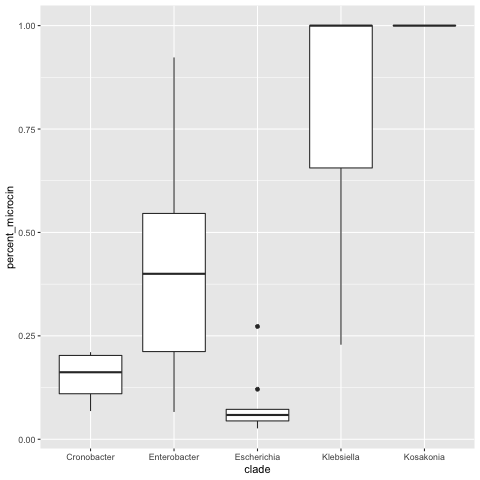

In [49]:
%%R
species_microcins %>%
	ggplot(aes( x = clade, y = percent_microcin)) + 
		geom_boxplot()
		

So that is basically what it needs to be, I also need to eventually filter this out by hmmer hits, but for now, I will go forward to get the tree plot going.

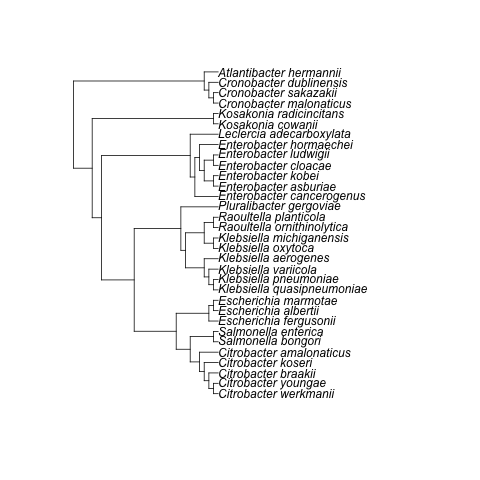

In [71]:
%%R
Enterobacteriaciae_species_tree$tip.label<-gsub("_"," ",Enterobacteriaciae_species_tree$tip.label)
species_microcins$species <- gsub("_"," ",species_microcins$species)
plot(Enterobacteriaciae_species_tree)

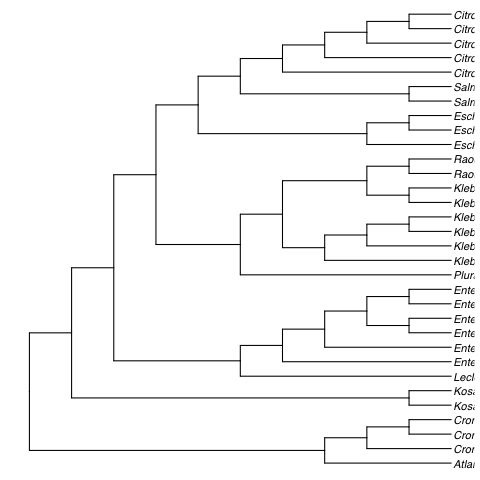

In [72]:
%%R 
species_tree_plot <- ggtree(Enterobacteriaciae_species_tree) +
	geom_tiplab(as_ylab=FALSE, fontface=3)
	#  xlim(0, 20) 
species_tree_plot

In [73]:
%%R
species_microcins$clade <- factor(species_microcins$clade, levels = c("Escherichia","Klebsiella","Enterobacter","Kosakonia","Cronobacter"))


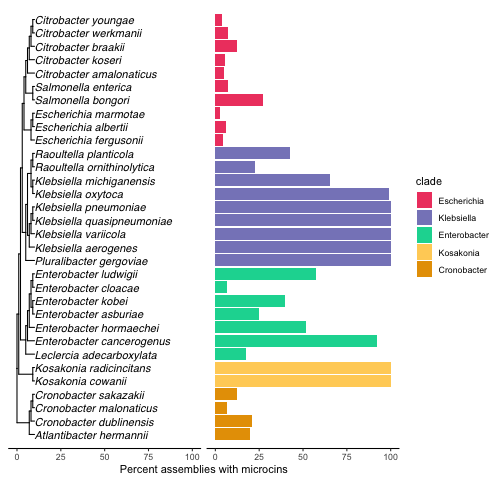

In [74]:
%%R -w 500
# species_tree_plot + 
# geom_facet(panel = "Trait", data = species_microcins, geom = geom_barh, 
#                 aes(x = percent_microcin), width = .6)
species_tree_microcin_plot <- facet_plot(species_tree_plot + xlim(0, 100), 
    panel = "percent microcin", 
    data = species_microcins,
    geom = geom_barh,
    mapping = aes(x = percent_microcin*100, fill = clade),
    stat="identity") +
    scale_fill_manual(values=c(
        "#ef476f", 
        "#8787C3", 
        "#06d6a0",
        "#ffd166",
        "#E79F00")) +
    theme_tree2(strip.background = element_blank(),
    strip.text.x = element_blank(), 
        # text = element_text(size = 20)
        ) +
    xlab("Percent assemblies with microcins")

    # xlim(0, 0.1)
species_tree_microcin_plot

So there are just a few things that need to be adressed here. The big thing is that the newick tree needs to be updated to have all species, since I did that by hand and may have left out about four species..

The next is just to filter based on hmmer hits.

I can make my life a little easier by pinpointing exactly which species are missing from the tree

In [69]:
%%R
species_microcins %>%
	filter(!(species %in% Enterobacteriaciae_species_tree$tip.label))


# A tibble: 3 × 5
  species                 n_microcins clade        assemblies percent_microcin
  <chr>                         <int> <fct>             <int>            <dbl>
1 Enterobacter hormaechei         417 Enterobacter        808           0.516 
2 Klebsiella pneumoniae           300 Klebsiella          300           1     
3 Salmonella enterica              58 Escherichia         799           0.0726


Alright, so these species have been left out. Just three of them!

For my own notes/sanity. 
1. Enterobacter hormaechei  -> sister to Enterobacter xiangfangensis
2. Klebsiella pneumoniae -> sister to Klebsiella quasipneumoniae
3. Salmonella enterica -> sister to Salmonella bongori


In [80]:
%%R
species_microcins_hmmer <- Enterobacteriaceae_best_hits %>%
	filter(component == "microcins.verified") %>%
	filter(hmmerHit == TRUE) %>%
	count(species, sample) %>% 
	count(species, name = "n_microcins") %>%
	full_join(speciesAssemblies) %>%
	mutate(percent_microcin = n_microcins / assemblies)

Joining, by = "species"


In [83]:
%%R
species_microcins_hmmer$species <- gsub("_"," ",species_microcins_hmmer$species)
species_microcins_hmmer$clade <- factor(species_microcins_hmmer$clade, levels = c("Escherichia","Klebsiella","Enterobacter","Kosakonia","Cronobacter"))

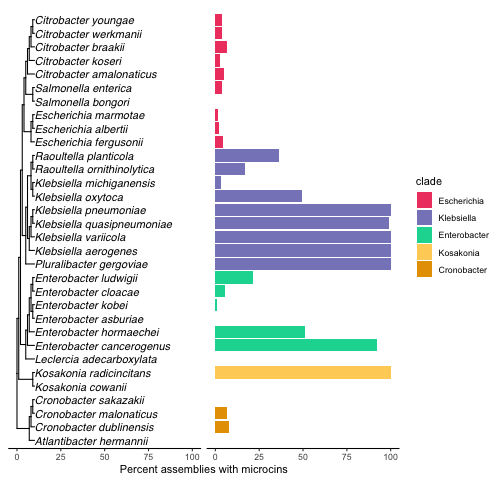

In [84]:
%%R -w 500
# species_tree_plot + 
# geom_facet(panel = "Trait", data = species_microcins, geom = geom_barh, 
#                 aes(x = percent_microcin), width = .6)
species_tree_microcin_plot <- facet_plot(species_tree_plot + xlim(0, 100), 
    panel = "percent microcin", 
    data = species_microcins_hmmer,
    geom = geom_barh,
    mapping = aes(x = percent_microcin*100, fill = clade),
    stat="identity") +
    scale_fill_manual(values=c(
        "#ef476f", 
        "#8787C3", 
        "#06d6a0",
        "#ffd166",
        "#E79F00")) +
    theme_tree2(strip.background = element_blank(),
    strip.text.x = element_blank(), 
        # text = element_text(size = 20)
        ) +
    xlab("Percent assemblies with microcins")

    # xlim(0, 0.1)
species_tree_microcin_plot

In [86]:
%%R 
species_tree_microcin_plot
ggsave("plots/05_Enterobacteriaceae_microcin_phylogeny.svg")

R[write to console]: Saving 6.67 x 6.67 in image



Alright, so I'm going to go ahead and say this is probably the most complete picture in terms of how many species are present, and how believable the hits are, since they are all hmmer hits.